To create a masked array where all values close to 1.e20 are invalid, we would do:

In [5]:
z = ma.masked_values([1.0, 1.e20, 3.0, 4.0], 1.e20)

### Constructing masked arrays

There are several ways to construct a masked array.
- Directly invoke the MaskedArray class
- Use the two masked array constructors, `array` and `masked_array`
- Take the view of an existing array. In that case, the mask of the view is set to `nomask` if the array has no named fields, or an array of boolean with the same structure as the array otherwise.

In [10]:
x = np.array([1, 2, 3])
x.view(ma.MaskedArray)

masked_array(data=[1, 2, 3],
             mask=False,
       fill_value=999999)

In [9]:
x = np.array([(1, 1.), (2, 2.)], dtype=[('a',int), ('b', float)])
x.view(ma.MaskedArray)

masked_array(data=[(1, 1.0), (2, 2.0)],
             mask=[(False, False), (False, False)],
       fill_value=(999999, 1.e+20),
            dtype=[('a', '<i8'), ('b', '<f8')])

## Accessing the data

The underlying data of a masked array can be accessed in several ways:
- through the data attribute. The output is a view of the array as a `numpy.ndarray` or one of its subclasses, depending on the type of the underlying data at the masked array creation.
- through the `__array__` method. The output is then a `numpy.ndarray`.
- by directly taking a view of the masked array as a `numpy.ndarray` or one of its subclass (which is actually what using the data attribute does).
- by using the `getdata` function.

**None of these methods is completely satisfactory if some entries have been marked as invalid.** As a general rule, where a representation of the array is required without any masked entries, it is recommended to fill the array with the `filled` method.

### Accessing the mask

The mask of a masked array is accessible through its `mask` attribute. We must keep in mind that a `True` entry in the mask indicates an invalid data.

Another possibility is to use the `getmask` and `getmaskarray` functions. `getmask(x)` outputs the mask of `x` if `x` is a masked array, and the special value `nomask` otherwise. `getmaskarray(x)` outputs the mask of `x` if `x` is a masked array. If `x` has no invalid entry or is not a masked array, the function outputs a boolean array of `False` with as many elements as `x`.

### Accessing only the valid entries

To retrieve only the valid entries, we can use the inverse of the mask as an index. The inverse of the mask can be calculated with the `numpy.logical_not` function or simply with the `~` operator:

In [11]:
x = ma.array([[1, 2], [3, 4]], mask=[[0, 1], [1, 0]])
x[~x.mask]

masked_array(data=[1, 4],
             mask=[False, False],
       fill_value=999999)

Another way to retrieve the valid data is to use the `compressed` method, which returns a one-dimensional `ndarray` (or one of its subclasses, depending on the value of the `baseclass` attribute):

In [13]:
x.compressed()

array([1, 4])

Note that the output of `compressed` is always 1D.

## Modifying the mask

### Masking an entry

The recommended way to mark one or several specific entries of a masked array as invalid is to assign the special value `masked` to them:

In [14]:
x = ma.array([1, 2, 3])
x[0] = ma.masked
x

masked_array(data=[--, 2, 3],
             mask=[ True, False, False],
       fill_value=999999)

In [15]:
y = ma.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
y[(0, 1, 2), (1, 2, 0)] = ma.masked
y

masked_array(
  data=[[1, --, 3],
        [4, 5, --],
        [--, 8, 9]],
  mask=[[False,  True, False],
        [False, False,  True],
        [ True, False, False]],
  fill_value=999999)

In [16]:
z = ma.array([1, 2, 3, 4])
z[:-2] = ma.masked
z

masked_array(data=[--, --, 3, 4],
             mask=[ True,  True, False, False],
       fill_value=999999)

**A second possibility is to modify the mask directly, but this usage is discouraged.**

**Note**

When creating a new masked array with a simple, non-structured datatype, the mask is initially set to the special value nomask, that corresponds roughly to the boolean False. Trying to set an element of nomask will fail with a TypeError exception, as a boolean does not support item assignment.

All the entries of an array can be masked at once by assigning `True` to the mask:

In [18]:
x = ma.array([1, 2, 3], mask=[0, 0, 1])
x.mask = True
x

masked_array(data=[--, --, --],
             mask=[ True,  True,  True],
       fill_value=999999,
            dtype=int64)

Finally, specific entries can be masked and/or unmasked by assigning to the mask a sequence of booleans:

In [19]:
x = ma.array([1, 2, 3])
x.mask = [0, 1, 0]
x

masked_array(data=[1, --, 3],
             mask=[False,  True, False],
       fill_value=999999)

### Unmasking an entry

To unmask one or several specific entries, we can just assign one or several new valid values to them:

In [20]:
x = ma.array([1, 2, 3], mask=[0, 0, 1])
x

masked_array(data=[1, 2, --],
             mask=[False, False,  True],
       fill_value=999999)

In [21]:
x[-1] = 5
x

masked_array(data=[1, 2, 5],
             mask=[False, False, False],
       fill_value=999999)

**Note**

Unmasking an entry by direct assignment will silently fail if the masked array has a hard mask, as shown by the `hardmask` attribute. This feature was introduced to prevent overwriting the mask. To force the unmasking of an entry where the array has a hard mask, the mask must first to be softened using the `soften_mask` method before the allocation. It can be re-hardened with `harden_mask`:

To unmask all masked entries of a masked array (provided the mask isn’t a hard mask), the simplest solution is to assign the constant `nomask` to the mask:

In [22]:
x = ma.array([1, 2, 3], mask=[0, 0, 1])
x

masked_array(data=[1, 2, --],
             mask=[False, False,  True],
       fill_value=999999)

In [23]:
x.mask = ma.nomask
x

masked_array(data=[1, 2, 3],
             mask=[False, False, False],
       fill_value=999999)

## Indexing and slicing

As a `MaskedArray` is a subclass of `numpy.ndarray`, it inherits its mechanisms for indexing and slicing.

When accessing a single entry of a masked array with no named fields, the output is either a scalar (if the corresponding entry of the mask is `False`) or the special value `masked` (if the corresponding entry of the mask is `True`):

In [24]:
x = ma.array([1, 2, 3], mask=[0, 0, 1])
x[0]

1

In [25]:
x[-1]

masked

In [26]:
x[-1] is ma.masked

True

If the masked array has named fields, accessing a single entry returns a `numpy.void` object if none of the fields are masked, or a 0d masked array with the same `dtype` as the initial array if at least one of the fields is masked.

In [28]:
y = ma.masked_array([(1,2), (3, 4)],
                    mask=[(0, 0), (0, 1)],
                    dtype=[('a', int), ('b', int)])

y[0]

(1, 2)

In [30]:
y[-1]

(3, --)

When accessing a slice, the output is a masked array whose data attribute is a view of the original data, and whose mask is either `nomask` (if there was no invalid entries in the original array) or a view of the corresponding slice of the original mask. The view is required to ensure propagation of any modification of the mask to the original.

In [32]:
x = ma.array([1, 2, 3, 4, 5], mask=[0, 1, 0, 0, 1])
mx = x[:3]
mx

masked_array(data=[1, --, 3],
             mask=[False,  True, False],
       fill_value=999999)

In [34]:
mx[1] = -1
mx

masked_array(data=[1, -1, 3],
             mask=[False, False, False],
       fill_value=999999)

In [35]:
x.mask

array([False, False, False, False,  True])

In [36]:
x.data

array([ 1, -1,  3,  4,  5])

Accessing a field of a masked array with structured datatype returns a `MaskedArray`.

## Operations on masked arrays

Arithmetic and comparison operations are supported by masked arrays. As much as possible, invalid entries of a masked array are not processed, meaning that the corresponding data entries should be the same before and after the operation.

**Warning**

We need to stress that this behavior may not be systematic, that masked data may be affected by the operation in some cases and therefore users should not rely on this data remaining unchanged.

The `numpy.ma` module comes with a specific implementation of most `ufuncs`. Unary and binary functions that have a validity domain (such as `log` or `divide`) return the masked constant whenever the input is masked or falls outside the validity domain:

In [37]:
ma.log([-1, 0, 1, 2])

masked_array(data=[--, --, 0.0, 0.6931471805599453],
             mask=[ True,  True, False, False],
       fill_value=1e+20)

Masked arrays also support standard `numpy` `ufuncs`. The output is then a masked array. The result of a unary `ufunc` is masked wherever the input is masked. The result of a binary `ufunc` is masked wherever any of the input is masked. 

In [38]:
x = ma.array([-1, 1, 0, 2, 3], mask=[0, 0, 0, 0, 1])
np.log(x)

/opt/miniconda3/envs/czidocs/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/opt/miniconda3/envs/czidocs/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


masked_array(data=[--, 0.0, --, 0.6931471805599453, --],
             mask=[ True, False,  True, False,  True],
       fill_value=1e+20)

# Examples
Data with a given value representing missing data

Let’s consider a list of elements, x, where values of -9999. represent missing data. We wish to compute the average value of the data and the vector of anomalies (deviations from the average):

In [39]:
import numpy.ma as ma
x = [0.,1.,-9999.,3.,4.]
mx = ma.masked_values (x, -9999.)
print(mx.mean())

2.0


In [40]:
print(mx - mx.mean())

[-2.0 -1.0 -- 1.0 2.0]


In [41]:
print(mx.anom())

[-2.0 -1.0 -- 1.0 2.0]


### Filling in the missing data

Suppose now that we wish to print that same data, but with the missing values replaced by the average value.

In [42]:
print(mx.filled(mx.mean()))

[0. 1. 2. 3. 4.]


# Numerical operations

Numerical operations can be easily performed without worrying about missing values, dividing by zero, square roots of negative numbers, etc.:

In [44]:
x = ma.array([1., -1., 3., 4., 5., 6.], mask=[0,0,0,0,1,0])
y = ma.array([1., 2., 0., 4., 5., 6.], mask=[0,0,0,0,0,1])
print(ma.sqrt(x/y))

[1.0 -- -- 1.0 -- --]


Four values of the output are invalid: the first one comes from taking the square root of a negative number, the second from the division by zero, and the last two where the inputs were masked.

## Ignoring extreme values

Let’s consider an array d of floats between 0 and 1. We wish to compute the average of the values of `d` while ignoring any data outside the range `[0.2, 0.9]`:

In [45]:
d = np.linspace(0, 1, 20)
print(d.mean() - ma.masked_outside(d, 0.2, 0.9).mean())

-0.05263157894736836


# END

In [12]:
import numpy as np

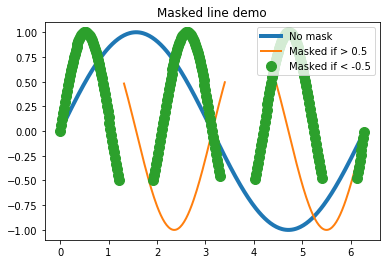

In [2]:
import matplotlib.pyplot as plt

x = np.arange(0, 2*np.pi, 0.02)
y = np.sin(x)
y1 = np.sin(2*x)
y2 = np.sin(3*x)
ym1 = np.ma.masked_where(y1 > 0.5, y1)
ym2 = np.ma.masked_where(y2 < -0.5, y2)

lines = plt.plot(x, y, x, ym1, x, ym2, 'o')
plt.setp(lines[0], linewidth=4)
plt.setp(lines[1], linewidth=2)
plt.setp(lines[2], markersize=10)

plt.legend(('No mask', 'Masked if > 0.5', 'Masked if < -0.5'),
           loc='upper right')
plt.title('Masked line demo')
plt.show()

A masked array contains an ordinary numpy array and a mask that indicates the position of invalid entries:
```python
np.ma.MaskedArray(data=arr, mask=invalid_mask)
```

Example:

In [10]:
import math
def is_prime(n):
    assert n > 1, 'Input must be larger than 1'
    if n % 2 == 0 and n > 2: 
        return False
    return all(n % i for i in range(3, int(math.sqrt(n)) + 1, 2))

arr = np.array(range(2,100))
non_prime_mask = [not is_prime(n) for n in arr]
prime_arr = np.ma.MaskedArray(data=arr, mask=non_prime_mask)
print(prime_arr)
# [2 3 -- 5 -- 7 -- -- -- 11 -- 13 -- -- -- 17 -- 19 -- -- -- 23 -- -- -- --
#  -- 29 -- 31 -- -- -- -- -- 37 -- -- -- 41 -- 43 -- -- -- 47 -- -- -- --
#  -- 53 -- -- -- -- -- 59 -- 61 -- -- -- -- -- 67 -- -- -- 71 -- 73 -- --
#  -- -- -- 79 -- -- -- 83 -- -- -- -- -- 89 -- -- -- -- -- -- -- 97 -- --]

arr = np.array(range(11))
print(arr.sum())        # 55

arr[-1] = -999 # indicates missing value
masked_arr = np.ma.masked_values(arr, -999)
print(masked_arr.sum()) # 45

[2 3 -- 5 -- 7 -- -- -- 11 -- 13 -- -- -- 17 -- 19 -- -- -- 23 -- -- -- --
 -- 29 -- 31 -- -- -- -- -- 37 -- -- -- 41 -- 43 -- -- -- 47 -- -- -- --
 -- 53 -- -- -- -- -- 59 -- 61 -- -- -- -- -- 67 -- -- -- 71 -- 73 -- --
 -- -- -- 79 -- -- -- 83 -- -- -- -- -- 89 -- -- -- -- -- -- -- 97 -- --]
55
45


Masking (indexing with masks of booleans):

```python
>>> mask = camera < 87
>>> # Set to "white" (255) the pixels where mask is True
>>> camera[mask] = 255
```

The mask can be any boolean array of the same shape as the image (or a shape broadcastable to the image shape).

Boolean operations from NumPy can be used to define even more complex masks:

```python
>>> lower_half = row > cnt_row
>>> lower_half_disk = np.logical_and(lower_half, outer_disk_mask)
>>> camera = data.camera()
>>> camera[lower_half_disk] = 0
```

We can also use 2D boolean masks for 2D multichannel images, as we did with the grayscale image above: Using a 2D mask on a 2D color image

```python
>>> from skimage import data
>>> cat = data.chelsea()
>>> reddish = cat[:, :, 0] > 160
>>> cat[reddish] = [0, 255, 0]
>>> plt.imshow(cat)
```

https://scipy-cookbook.readthedocs.io/items/ViewsVsCopies.html

In [12]:
a = np.arange(10)
a

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [13]:
v1 = a[1:2]
v1

array([1])

In [14]:
a[1] = 2
v1

array([2])

In [15]:
v2 = a[1::3]
v2

array([2, 4, 7])

In [16]:
a[7] = 10
v2

array([ 2,  4, 10])

dtype views

In [23]:
b = np.arange(10, dtype='int16')
b

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int16)

In [24]:
v3 = b.view('int32')
v3

array([ 65536, 196610, 327684, 458758, 589832], dtype=int32)

In [25]:
v3 += 1
b

array([1, 1, 3, 3, 5, 5, 7, 7, 9, 9], dtype=int16)

In [26]:
v4 = b.view('int8')
v4

array([1, 0, 1, 0, 3, 0, 3, 0, 5, 0, 5, 0, 7, 0, 7, 0, 9, 0, 9, 0],
      dtype=int8)

In [27]:
b.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

In [28]:
v4.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False